In [3]:
import os
os.chdir("/gpfs/home/asun/jin_lab/get/GEARS/demo/")
print(os.getcwd())
import sys
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
from scipy.stats import pearsonr

from gears import PertData
from gears.inference import evaluate, compute_metrics, deeper_analysis

pert_data = PertData('./data')
pert_data.load(data_path = './data/zheng')
pert_data.prepare_split(split = 'simulation_single', seed = 1)
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)

from gears import GEARS
gears_model = GEARS(pert_data, device = 'cuda:0',
                    weight_bias_track = True, 
                    proj_name = 'gears', 
                    exp_name = 'zheng_uncertain')

## train a uncertainty-aware model, specify uncertainty to True
gears_model.model_initialize(uncertainty = True)
gears_model.train(epochs = 20)
gears_model.save_model('gears_unc')

## load a pretrained uncertainty model
#gears_model.load_pretrained('pertnet_unc')

Found local copy...


/gpfs/group/jin/asun/get/GEARS/demo


Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
[]
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


here1


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Found local copy...
Start Training...
Epoch 1 Step 1 Train Loss: 1.5496
Epoch 1 Step 51 Train Loss: 0.6890
Epoch 1 Step 101 Train Loss: 0.6608
Epoch 1 Step 151 Train Loss: 0.6344
Epoch 1 Step 201 Train Loss: 0.5999
Epoch 1: Train Overall MSE: 0.0021 Validation Overall MSE: 0.0023. 
Train Top 20 DE MSE: 0.0113 Validation Top 20 DE MSE: 0.0365. 
Epoch 2 Step 1 Train Loss: 0.5677
Epoch 2 Step 51 Train Loss: 0.5830
Epoch 2 Step 101 Train Loss: 0.5932
Epoch 2 Step 151 Train Loss: 0.5712
Epoch 2 Step 201 Train Loss: 0.6003
Epoch 2: Train Overall MSE: 0.0025 Validation Overall MSE: 0.0020. 
Train Top 20 DE MSE: 0.0091 Validation Top 20 DE MSE: 0.0409. 
Epoch 3 Step 1 Train Loss: 0.5472
Epoch 3 Step 51 Train Loss: 0.6344
Epoch 3 Step 101 Train Loss: 0.5885
Epoch 3 Step 151 Train Loss: 0.5000
Epoch 3 Step 201 Train Loss: 0.5607
Epoch 3: Train Overall MSE: 0.0016 Validation Overall MSE: 0.0016. 
Train Top 20 DE MSE: 0.0062 Validation Top 20 DE MSE: 0.0405. 
Epoch 4 Step 1 Train Loss: 0.5317
Epoc

In [4]:
test_res = evaluate(gears_model.dataloader['test_loader'], gears_model.model, gears_model.config['uncertainty'], gears_model.device)
test_metrics, test_pert_res = compute_metrics(test_res)
out = deeper_analysis(gears_model.adata, test_res)

In [15]:
test_pert_res

{'NR2F1+ctrl': {'mse': 0.00059376087,
  'pearson': 0.9978327966244946,
  'mse_de': 0.0067761615,
  'pearson_de': 0.991077119622787}}

In [6]:
pert2unc = pd.DataFrame(tuple(zip(test_res['pert_cat'], np.mean(test_res['logvar'], axis = 1)))).groupby(0).agg(np.mean)
pert2unc = dict(zip(pert2unc.index.values, pert2unc.values))

metric = 'pearson_delta'
stats_summary = [np.exp(-pert2unc[i][0]) for i in test_pert_res.keys() if metric in out[i]]
metric_summary = [out[i][metric] for i in test_pert_res.keys() if metric in out[i]]
print(pearsonr(stats_summary, metric_summary))

ValueError: `x` and `y` must have length at least 2.

In [7]:
stats_summary

[1.3880764]

In [8]:
metric_summary

[0.052290800727834985]

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.color_palette("Set2").as_hex()

def plot(stats_summary, metric_summary):

    ax = sns.regplot(x=np.array(stats_summary),
                    y=np.array(metric_summary), 
                    color = pal[2],
                     ci = None
                    )

    sns.despine()

    plt.ylabel("Pearson Correlation with True Delta \n Expression Across All Genes",labelpad=10)
    plt.xlabel("Predicted Uncertainty",labelpad=10)
    plt.tick_params(axis='x', which='major', pad=10)
    plt.tick_params(axis='y', which='major', pad=5)
    plt.savefig('uncertainty.pdf', bbox_inches='tight')
    
    plt.show()
    
    top = np.quantile(np.array(list(pert2unc.values())), 0.95)

    m = 'pearson_delta'
    ax = sns.distplot([i[m] for k, i in out.items() if (pert2unc[k][0] < top) and (m in i)], hist = False, color = "black")
    ax = sns.distplot([i[m] for k, i in out.items() if (pert2unc[k][0] > top) and (m in i)], hist = False, color = "Red")

    print('---- ' + m + '----')
    total_mean = np.mean([i[m] for k, i in out.items() if (pert2unc[k][0] < top) and (m in i)])
    after_filter_mean = np.mean([i[m] for k, i in out.items() if (pert2unc[k][0] > top) and (m in i)])
    print('Total Mean: ' + str(total_mean))
    print('After uncertainty filter Mean: ' + str(after_filter_mean))
    print('Enrichment: ' + str((after_filter_mean - total_mean)/total_mean))

    sns.despine()
    ax.set_xlim((-0.24,1.24))
    plt.xlabel("Pearson Correlation with True Delta \n Expression Across All Genes",labelpad=10)
    plt.ylabel("Density of Perturbations",labelpad=10)
    plt.tick_params(axis='x', which='major', pad=10)
    plt.tick_params(axis='y', which='major', pad=5)
    plt.savefig('prioritize_uncertainty.pdf', bbox_inches='tight')
    plt.show()


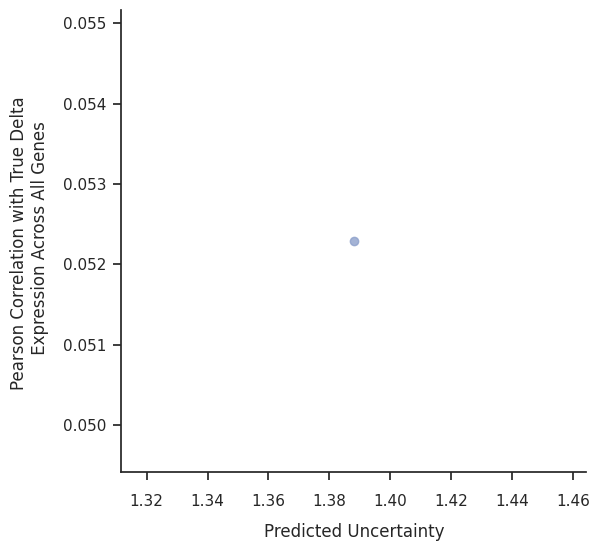

---- pearson_delta----
Total Mean: nan
After uncertainty filter Mean: nan
Enrichment: nan


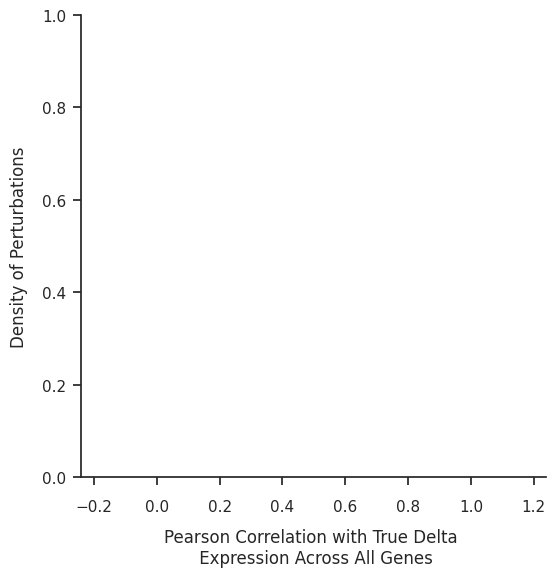

In [17]:
plot(stats_summary, metric_summary)